<a href="https://colab.research.google.com/github/doudi25/Algerian-nlp-dataset-classification/blob/main/Copie_de_Untitled105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cudf
df=cudf.read_csv('total.csv')

In [1]:
!unzip doud.zip

Archive:  doud.zip
  inflating: total.csv               


In [3]:
comment=df['comment']


In [4]:
y=df['Topic']

In [5]:
y=y.to_pandas()

In [6]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)

In [7]:
import numpy as np
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [8]:
X=list(comment.to_pandas())

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from nltk.tokenize import word_tokenize
tokenized_data = [word_tokenize(sentence.lower()) for sentence in X]


In [11]:
from gensim.models import Word2Vec
embedding_model = Word2Vec(
    tokenized_data,
    hs=1,
    sg=1,
    vector_size=100,
    window=10,
    workers=2,
    min_count=1,
    seed=0,
    negative=0
)


In [12]:
embedding_model.train(tokenized_data,total_examples=embedding_model.corpus_count,epochs=250,report_delay=1)


(17598594, 19303750)

In [13]:
def get_embed(token):
  sentence=[embedding_model.wv[word]  for word in token if word in embedding_model.wv ]
  return sentence

In [14]:
def dataset_embed(dataset):
  embed_dataset=[]
  for sentence in dataset:
    embed_dataset.append(get_embed(sentence))
  return embed_dataset

In [15]:
embedded_dataset=dataset_embed(tokenized_data)

In [53]:
def padding(dataset,desired_length=60):
  padded_dataset=[]
  for i,a in enumerate(dataset):
    array=np.array(a)
    length=array.shape[0]
    diff= desired_length-length
    if diff>0:
      pad = np.zeros(shape=(diff, 100))
      X_copy = np.concatenate([array, pad])
      padded_dataset.append(X_copy)
    else:
      padded_dataset.append(array[:desired_length])
  return padded_dataset


In [54]:
final_dataset=padding(embedded_dataset)

In [55]:
final_dataset=np.array(final_dataset)

In [56]:
final_dataset.shape

(7522, 60, 100)

In [20]:
def distribution(X):
  length=[]
  for i in range(len(X)):
    length.append(len(X[i]))
  return length
distribution=distribution(X)

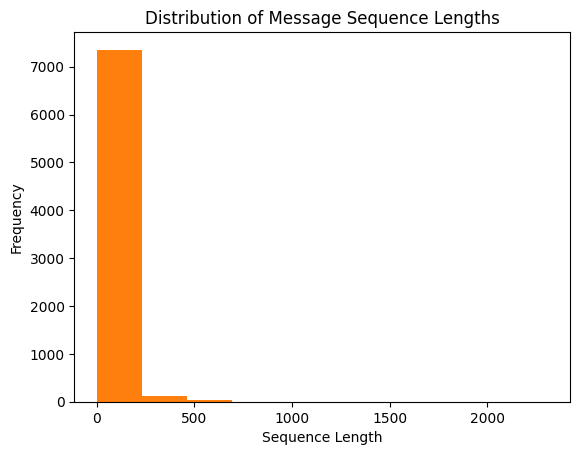

In [ ]:
import matplotlib.pyplot as plt
plt.hist(distribution)
plt.hist(distribution)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Sequence Lengths')
plt.show()


In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_dataset,y,test_size=0.2,shuffle=True)

In [58]:
from keras import layers
import keras
model=keras.Sequential()
model.add(layers.Input(shape=(60,100)))
model.add(layers.LSTM(32,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32,return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(32,return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(20,activation='softmax'))
model.build()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 32)            17024     
                                                                 
 dropout_15 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_16 (LSTM)              (None, 60, 32)            8320      
                                                                 
 dropout_16 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 32)            8320      
                                                                 
 dropout_17 (Dropout)        (None, 60, 32)            0         
                                                                 
 flatten_5 (Flatten)         (None, 1920)             

In [59]:

model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [61]:

model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30
189/189 [==============================] - 7s 22ms/step - loss: 2.3749 - accuracy: 0.2146 - val_loss: 2.2594 - val_accuracy: 0.2591
Epoch 2/30
189/189 [==============================] - 3s 16ms/step - loss: 2.1840 - accuracy: 0.2809 - val_loss: 2.2097 - val_accuracy: 0.2671
Epoch 3/30
189/189 [==============================] - 2s 12ms/step - loss: 2.0660 - accuracy: 0.3242 - val_loss: 2.1971 - val_accuracy: 0.2877
Epoch 4/30
189/189 [==============================] - 2s 12ms/step - loss: 1.9752 - accuracy: 0.3510 - val_loss: 2.1763 - val_accuracy: 0.3017
Epoch 5/30
189/189 [==============================] - 2s 12ms/step - loss: 1.8874 - accuracy: 0.3816 - val_loss: 2.1749 - val_accuracy: 0.3043
Epoch 6/30
189/189 [==============================] - 2s 13ms/step - loss: 1.8025 - accuracy: 0.4085 - val_loss: 2.1954 - val_accuracy: 0.3056
Epoch 7/30
189/189 [==============================] - 3s 17ms/step - loss: 1.7339 - accuracy: 0.4333 - val_loss: 2.1964 - val_accuracy: 0.3216

In [68]:
predictions=model.predict(X_test)

48/48 [==============================] - 0s 7ms/step


In [69]:
y_labels=np.argmax(predictions,axis=1)

In [70]:
print(y_labels[:20])
print(Y_test[:20])

[14 11 11 12  7  1 14 14 13 13  5 16 11 13  8  7 16 13 18 11]
[ 5 11  5 12  7 11 15 14 13 14 14 15 11 15 10  7 14  7 13 11]
